## Import Libs

In [13]:
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import dataset_utils
import os
import utils

In [ ]:
%matplotlib inline

In [7]:
device = torch.device('cuda:7')

## Load dataset & model

In [8]:
dataset = dataset_utils.load_dataset('cifar10')(batch_size=64, doNormalization=True, inj_rate=0.9)

CIFAR10::init - doNormalization is True
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
x_train = dataset.train.data
x_test = dataset.test.data
y_train = dataset.train.targets
y_test = dataset.test.targets
x_train_backdoor = dataset.train_backdoor.data
x_test_backdoor = dataset.test_backdoor.data
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_backdoor = x_train_backdoor.astype('float32')/255
x_test_backdoor = x_test_backdoor.astype('float32')/255

In [10]:
num_classes = 10
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

In [11]:
from networks.CNNs.VGG import VGG16
from networks.CNNs.ResNet import ResNet56
from networks.CNNs.MobileNet import MobileNet

In [14]:
num_classes = 10
input_size = 32
sdn_model = utils.get_sdn_model('mobilenet',utils.get_add_output('mobilenet'),num_classes, input_size)
sdn_model.load_state_dict(torch.load('./BackdoorSDN/models/mobilenet_cifar10/epoch100/copy1/copy8/retrain_sdn_10.pt'))
sdn_model.eval()
sdn_model.to(device=device)
model = utils.sdn_to_cnn(sdn_model, device)
model.eval()
model.to(device=device)

[sdn_to_cnn] convert an SDN to a CNN...


MobileNet(
  (init_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layers): ModuleList(
    (0): Block(
      (layers): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): Block(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3)

## Using STRIP to detect the backdoor

In [15]:
def model_predict(x,n):
    py1 = []
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    trans = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])
    for i in range(n):
        softmax = nn.Softmax()
        im_data = trans(x[i])
        im_data = im_data.to(device)
        im_data = im_data.resize(1, 3, 32, 32)
        outputs = softmax(model(im_data))
        preds = outputs.cpu()
        pred = preds.detach().numpy()
        py1.append(pred)
    return py1

In [16]:
import math
import random
import time
import scipy
  
def superimpose(background, overlay):
    
    added_image = cv2.addWeighted(background,0.5,overlay,0.5,0)
    return (added_image.reshape(32,32,3))

def entropyCal(background, n):
    entropy_sum = [0] * n
    x1_add = [0] * n
    index_overlay = np.random.randint(20000,29999, size=n)
    for x in range(n):
        x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))
    
    py1_add = model_predict(np.array(x1_add),n)
    EntropySum = -np.nansum(py1_add*np.log2(py1_add))
    #EntropySum = np.nansum(py1_add)
    return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
    if 0 == j%100:
        print(j)
    x_background = x_train[j+26000] 
    entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
    if 0 == j%100:
        print(j)
    x_poison = x_train_backdoor[j+14000]
    entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0


/home/kemove/anaconda3/envs/pytorch_1_10/lib/python3.8/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/tmp/ipykernel_2201602/552800488.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = softmax(model(im_data))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [4]:
zero_list = [0]*200

## Plot the results

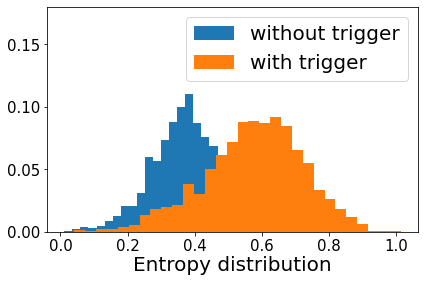

In [19]:
entropy_benigh_cifar10_res = entropy_benigh
entropy_trojan_cifar10_res = entropy_trojan
bins = 30
plt.hist(entropy_benigh_cifar10_res, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trigger')
plt.hist(entropy_trojan_cifar10_res, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trigger')
#plt.hist(zero_list, bins, weights=np.ones(len(zero_list)) / 200, alpha=1,color = 'red',width = 0.01)
#plt.annotate('typical\nbackdoor\nmodel',(0.01,0.13),(0.1,0.13),color="red",fontsize = 18,arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color="r"))
plt.legend(loc='upper right', fontsize = 20)
#plt.ylabel('Probability (%)', fontsize = 15)
plt.ylim(0,0.18)
#plt.xlim(-0.1,1.7)
plt.title('Entropy distribution', fontsize = 20,y=-0.2)
plt.tick_params(labelsize=15)

fig1 = plt.gcf()
plt.tight_layout()
plt.savefig('./STRIP/cifar10_mobilenet.png',dpi=1000)
plt.show()